In [ ]:
! pip install -q transformers
! pip install -q datasets

from transformers import (CLIPProcessor, CLIPModel, CLIPTextModel, AutoTokenizer, AutoProcessor, CLIPVisionModel)
from datasets import load_dataset
from matplotlib import pyplot as plt
import numpy as np
import math
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
import itertools
from PIL import Image
from zipfile import ZipFile

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 8.2 MB/s eta 0:00:00


## Downloading the model

In [ ]:
# Name of the pre-trained base model
base_model_name = 'openai/clip-vit-base-patch32'

# Pre-trained CLIP model
model = CLIPModel.from_pretrained(base_model_name)
processor = CLIPProcessor.from_pretrained(base_model_name)

## Understanding if CLIP can see differences in attributes

In [ ]:
class CLIPWrapper:
    ATTRIBUTES = ['shape', 'size', 'color']
    def __init__(self, clip_model, clip_processor, template:str):
        self.clip_model = clip_model
        self.clip_processor = clip_processor
        self.template = template

    def _prompts(self):
        """return text prompts for CLIP"""
        prompts = []
        for attr in CLIPWrapper.ATTRIBUTES:
            for t in self.template:
                prompts.append(t.format(attr=attr))
        return prompts

    def set_template(self, template:str):
        self.template = template

    def __call__(self, x):
        texts = self._prompts()
        inputs = self.clip_processor(text=texts, images=x, return_tensors="pt", padding=True)
        outputs = self.clip_model(**inputs)

        # given M images, N texts, output shape will be M x N
        logits_per_image = outputs.logits_per_image # this is the image-text similarity score
        N_img, N_txt = logits_per_image.shape
        N_temp = len(self.template)
        N_attr = len(CLIPWrapper.ATTRIBUTES)
        assert N_txt == N_attr*N_temp, f'Num text ({N_txt}) != Num template x Num attrs ({N_temp}x{N_attr}={N_temp*N_attr})'

        logits_data = logits_per_image.data.reshape(N_img, N_attr, N_temp)

        return logits_data.softmax(dim=-1)

    def pred(self, x):
        probs = self(x)
        return probs.argmax(dim=-1)

In [ ]:
# the template is used to generate prompts for our model
template = ['the two objects have the same {attr}', # first is the positive case
    'the two objects have different {attr}']        # second is the negative case

# wrapper object to hold the template and do predictions
wrapper = CLIPWrapper(model, processor, template)

# simple demo of how the model works. Download some images and input their 
# names here to see how they work
show_demo = True                           # set this to True
if show_demo:
    img_names = ['0000.jpg', '0001.jpg']    # write image file names here
    input = [Image.open(img) for img in img_names]
    print(wrapper(input))
    print()
    print(wrapper.pred(input))
else:
    print('Not showing demo')

tensor([[[0.5077, 0.4923],
         [0.4867, 0.5133],
         [0.5567, 0.4433]],

        [[0.4234, 0.5766],
         [0.2698, 0.7302],
         [0.3561, 0.6439]]])

tensor([[0, 1, 0],
        [1, 1, 1]])


## Loading our dataset

In [ ]:
with ZipFile('My_Dataset.zip', 'r') as f:
    f.extractall()

dataset_train = load_dataset('My_Dataset', split='train')
dataset_test = load_dataset('My_Dataset', split='test')
print(dataset_train.shape)
print(dataset_test.shape)

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset my_dataset downloaded and prepared to /root/.cache/huggingface/datasets/my_dataset/default/0.0.0/50eedd889ae61a15422f2ba70d6b7785316e8679761ccba58165cb4406d82907. Subsequent calls will reuse this data.
(12, 4)
(9, 4)


### Viewing some data points from the dataset

1
1
1


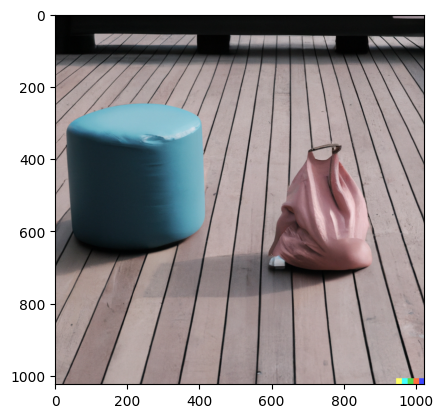

In [ ]:
idx = 1
print(dataset_train[idx]['shape'])
print(dataset_train[idx]['size'])
print(dataset_train[idx]['color'])
plt.imshow(dataset_train[idx]['image'])

0
1
0


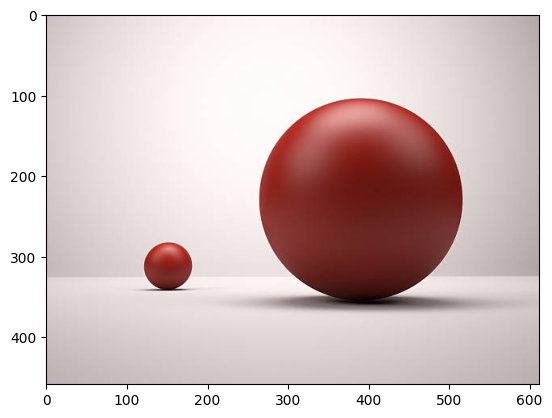

In [ ]:
idx = 5
print(dataset_train[idx]['shape'])
print(dataset_train[idx]['size'])
print(dataset_train[idx]['color'])
plt.imshow(dataset_train[idx]['image'])

1
1
1


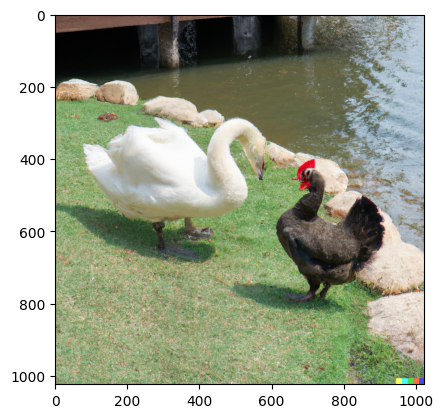

In [ ]:
idx = 0
print(dataset_test[idx]['shape'])
print(dataset_test[idx]['size'])
print(dataset_test[idx]['color'])
plt.imshow(dataset_test[idx]['image'])

## Predictions using CLIP

In [ ]:
def get_X_Y(dataset):
    """Return `list` of images with length `N_data` as `X`,
    and `torch.Tensor` of labels with shape `(N_data, N_attr)` as `Y`"""
    X, Y = [], []
    for item in dataset:
        X.append(item['image'])
        Y.append([item[attr] for attr in CLIPWrapper.ATTRIBUTES])
    return X, torch.tensor(Y)

def get_accuracy(Y_pred, Y_true, print_results=False):
    """Get `dict` with attributes as keys and their accuracies as values"""
    accs = dict()
    for i, attr in enumerate(CLIPWrapper.ATTRIBUTES):
        y_pred = Y_pred[:, i]
        y_true = Y_true[:, i]
        accs[attr] = accuracy_score(y_true, y_pred)

    # print if needed
    if print_results:
        for k, v in accs.items():
            print(f'Accuracy for {k}: {v*100:.2f}%')

    return accs

In [ ]:
X_train, Y_train = get_X_Y(dataset_train)
Y_train

tensor([[0, 0, 0],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 0],
        [0, 1, 0],
        [1, 1, 1],
        [1, 1, 1],
        [0, 0, 1],
        [1, 0, 1],
        [1, 1, 1],
        [0, 0, 1]])

In [ ]:
preds_train = wrapper.pred(X_train)
preds_train

tensor([[0, 1, 1],
        [1, 1, 0],
        [0, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [0, 1, 0],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 0],
        [1, 1, 1],
        [1, 1, 1]])

In [ ]:
train_accuracy = get_accuracy(preds_train, Y_train, print_results=True)

Accuracy for shape: 58.33%
Accuracy for size: 66.67%
Accuracy for color: 50.00%


## Trying out different templates

In [ ]:
template = ['An image showing two objects that have the same {attr}',
    'An image showing two objects that have different {attr}']
wrapper.set_template(template)
preds_train = wrapper.pred(X_train)
train_accuracy = get_accuracy(preds_train, Y_train, print_results=True)

Accuracy for shape: 66.67%
Accuracy for size: 50.00%
Accuracy for color: 83.33%


In [ ]:
template = ['There are two objectes. The {attr} of the first one is the same as that of the second.',
    'There are two objectes. The {attr} of the first one is different from that of the second.']
wrapper.set_template(template)
preds_train = wrapper.pred(X_train)
train_accuracy = get_accuracy(preds_train, Y_train, print_results=True)

Accuracy for shape: 75.00%
Accuracy for size: 66.67%
Accuracy for color: 58.33%


In [ ]:
template = ['Same {attr}',
    'Different {attr}']
wrapper.set_template(template)
preds_train = wrapper.pred(X_train)
train_accuracy = get_accuracy(preds_train, Y_train, print_results=True)

Accuracy for shape: 8.33%
Accuracy for size: 58.33%
Accuracy for color: 41.67%
